In [85]:
%pylab inline
import pysiaf
import webbpsf
from matplotlib import patches
import datetime

Populating the interactive namespace from numpy and matplotlib


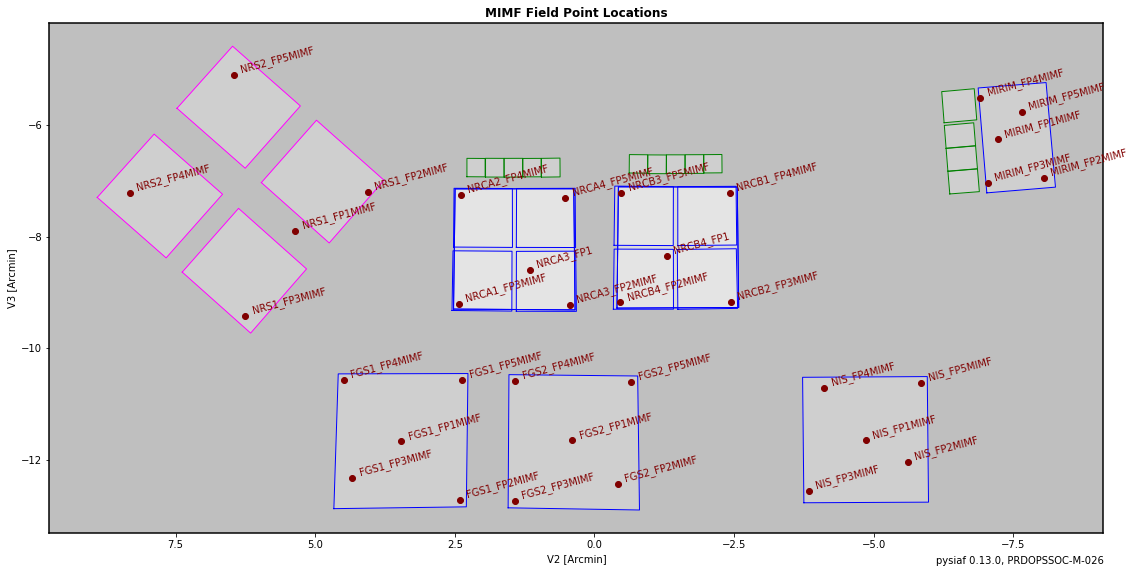

In [3]:

fig = plt.figure(figsize=(16,8))
ax = plt.gca()
ap_color='maroon'

pysiaf.siaf.plot_main_apertures(units='arcmin', fill_color='white', zorder=-1, fill_alpha=0.25, ax=ax)
ax.set_xlabel("V2 [Arcmin]")
ax.set_ylabel("V3 [Arcmin]")
ax.patch.set_facecolor('0.75')


for instname in webbpsf.instrument.list + ['fgs']:
    siaf = pysiaf.Siaf(instname)
    mimf_aperture_names = [m for m in siaf.apernames if ('MIMF' in m or m.endswith('_FP1'))]
    for apname in mimf_aperture_names:
        ap = siaf[apname]
        plt.scatter(ap.V2Ref/60, ap.V3Ref/60, marker='o', color=ap_color)
        plt.text(ap.V2Ref/60-0.10, ap.V3Ref/60, ap.AperName, color=ap_color,
                verticalalignment='bottom', rotation=15)
ax.set_title("MIMF Field Point Locations", fontweight='bold')

plt.text(1.0, -0.06, f"pysiaf {pysiaf.__version__}, {pysiaf.prd_list[-1]}",
         transform=ax.transAxes, horizontalalignment='right')

plt.tight_layout()
#plt.savefig("mimf_field_point_locations.pdf")

reference_plot_xlim = ax.get_xlim()
reference_plot_ylim = ax.get_ylim()





In [4]:
# Load the table of ISIM field points so we can match 'em up

import astropy
import webbpsf
import os

isimdatapath = os.path.join(webbpsf.utils.get_webbpsf_data_path(), 'si_zernikes_isim_cv3.fits')
isimdata = astropy.table.Table.read(isimdatapath)


def closest_isim_fp_name(targv2, targv3):
    r = np.sqrt(  (isimdata['V2']-targv2)**2 + (isimdata['V3']-targv3)**2)
    closest = np.argmin(r)
    return isimdata['field_point_name'][closest]

closest_isim_fp_name(-1, -10.5), closest_isim_fp_name(-2.5, -7), closest_isim_fp_name(6, -9)

('ISIM21', 'ISIM8', 'ISIM3')

In [22]:
# Read WAG field point info too

import openpyxl
from openpyxl import load_workbook

wb = load_workbook(filename = 'MIMF_FP_Table_From_WAG.xlsx')
sheet = wb['Sheet1']

wag_group = [c[0].value for c in sheet['A5:A34']]
wag_group[0] = 1 # fix what's '1 *' in the Excel

wag_fps = [c[0].value for c in sheet['B5:B34']]
wag_v2v3 = [c[0].value for c in sheet['F5:F34']]

wag_v2s = np.asarray([(w.split(',')[0]) for w in wag_v2v3], float)
wag_v3s = np.asarray([(w.split(',')[1]) for w in wag_v2v3], float)

def closest_wag_fp_group(targv2, targv3):
    r = np.sqrt(  (wag_v2s-targv2)**2 + (wag_v3s-targv3)**2)
    closest = np.argmin(r)
    if r[closest] > 0.1:
        print(targv2, wag_v2s[closest], targv3, wag_v3s[closest], r[closest])
        raise RuntimeError("Threshold exceeded for this FP")
    return wag_group[closest]


Populating the interactive namespace from numpy and matplotlib


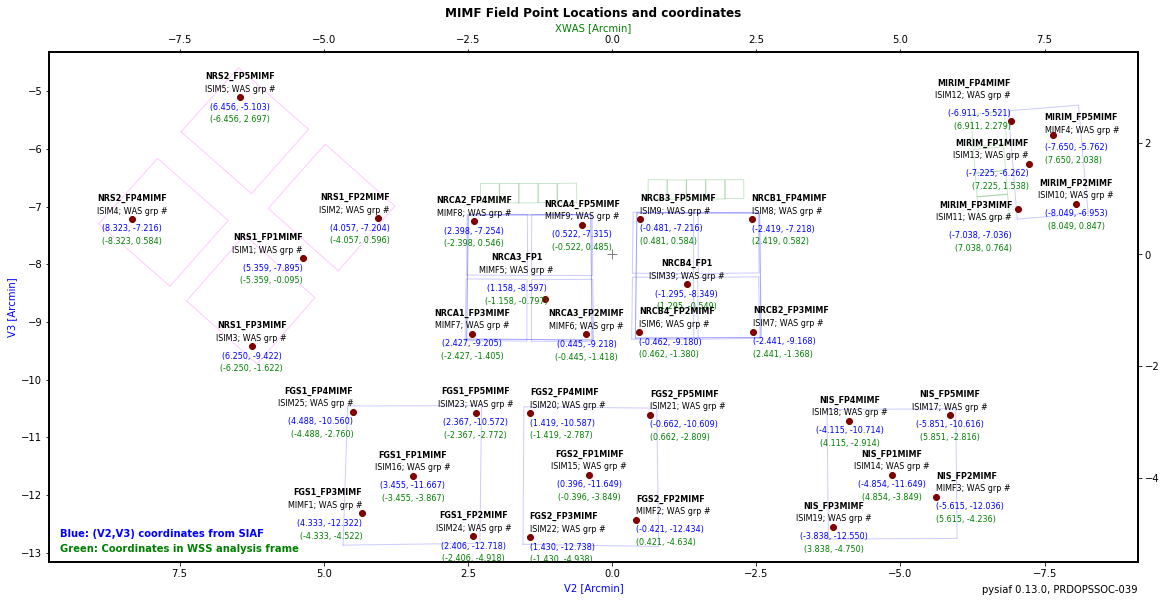

In [86]:
%pylab inline
import pysiaf
import webbpsf

fig = plt.figure(figsize=(16,8))
ax = plt.gca()
ap_color='maroon'

pysiaf.siaf.plot_main_apertures(ax=ax, units='arcmin', fill=True, 
                                fill_color='white', zorder=-1, fill_alpha=0.25, 
                                alpha=0.2)
ax.set_xlabel("V2 [Arcmin]", color='blue')
ax.set_ylabel("V3 [Arcmin]", color='blue')


#ax.patch.set_facecolor('0.75')

text_angle = 0

text_align_left = ['NRCB1_FP4MIMF','NRCB2_FP3MIMF', 'NRCB4_FP2MIMF', 'NRCB3_FP5MIMF',
                   'FGS2_FP4MIMF', 'FGS2_FP3MIMF', 'FGS2_FP5MIMF', 'FGS2_FP2MIMF',
                   'NIS_FP2MIMF',  'MIRIM_FP5MIMF']  # 'MIRIM_FP2MIMF',

text_align_right = ['MIRIM_FP1MIMF', 'MIRIM_FP3MIMF','MIRIM_FP4MIMF',
                    'FGS1_FP3MIMF', 'FGS1_FP4MIMF',
                    'NRS1_FP1MIMF', 'NRS1_FP2MIMF']


def label_offset(fpname):
    special_offsets = {'NRCA3_FP1': (0.5, 0.35),
                      'MIRIM_FP4MIMF': (0, 0.3),
                      'MIRIM_FP3MIMF': (0.1, -0.3),
                      'MIRIM_FP5MIMF': (0.15, -0.05),
                      'NRS1_FP2MIMF': (-0.2, 0)}
    
    return special_offsets.get(fpname, (0,0))


for instname in webbpsf.instrument.list + ['fgs']:
    siaf = pysiaf.Siaf(instname)
    mimf_aperture_names = [m for m in siaf.apernames if ('MIMF' in m or m.endswith('_FP1'))]
    for apname in mimf_aperture_names:
        ap = siaf[apname]
        plt.scatter(ap.V2Ref/60, ap.V3Ref/60, marker='o', color=ap_color)
                    
        h_align = 'left' if ap.AperName in text_align_left else 'right' if ap.AperName in text_align_right else 'center'
        
        WSS_XAN = -ap.V2Ref/60
        WSS_YAN = (ap.V3Ref+468)/60
        
        isim_name = closest_isim_fp_name(ap.V2Ref/60, ap.V3Ref/60)
        
        offset = label_offset(apname)
        
        text_kws = {'verticalalignment':'top',
                   'horizontalalignment':h_align,
                   'rotation':text_angle,
                   'fontsize': 8}
        
        
        plt.text(ap.V2Ref/60+offset[0], ap.V3Ref/60+0.44+offset[1],
                 f"{ap.AperName}", 
                 color='black', fontweight='bold',
                 **text_kws)
        plt.text(ap.V2Ref/60+offset[0], ap.V3Ref/60+0.44+offset[1]-0.22,
                 f"{isim_name}; WAS grp #", 
                 color='black', fontweight='normal',
                 **text_kws)
        plt.text(ap.V2Ref/60+offset[0], ap.V3Ref/60-0.09+offset[1],
                 f"({ap.V2Ref/60:.3f}, {(ap.V3Ref)/60:.3f})", color='blue', 
                 **text_kws)
        plt.text(ap.V2Ref/60+offset[0], ap.V3Ref/60-0.09+offset[1]-0.22,
                 f"({WSS_XAN:.3f}, {WSS_YAN:.3f})", color='green', 
                 **text_kws)


ax.set_title("MIMF Field Point Locations and coordinates", fontweight='heavy')

plt.text(1.0, -0.06, f"pysiaf {pysiaf.__version__}, {pysiaf.JWST_PRD_VERSION}",
         transform=ax.transAxes, horizontalalignment='right',)

plt.text(0.01, 0.05, f"Blue: (V2,V3) coordinates from SIAF",
         transform=ax.transAxes, horizontalalignment='left', fontweight='bold',
         color='blue')
plt.text(0.01, 0.02, f"Green: Coordinates in WSS analysis frame",
         transform=ax.transAxes, horizontalalignment='left', fontweight='bold',
         color='green')


plt.tight_layout()
#plt.savefig("mimf_field_point_locations_for_was.pdf")

reference_plot_xlim = ax.get_xlim()
reference_plot_ylim = ax.get_ylim()


# Set up additional axes labels in the coords that the WSS uses
ax_was = ax.twinx().twiny()
ax_was.set_xlabel("XWAS [Arcmin]", color='green')
ax_was.set_ylabel("YWAS [Arcmin]", color='green')
ax_was.set_xlim(*(-np.asarray(ax.get_xlim())))
ax_was.set_ylim(*(np.asarray(ax.get_ylim())+468/60))

ax_was.scatter(0,0, s=100, marker='+', color='black', alpha=0.5 )

Populating the interactive namespace from numpy and matplotlib


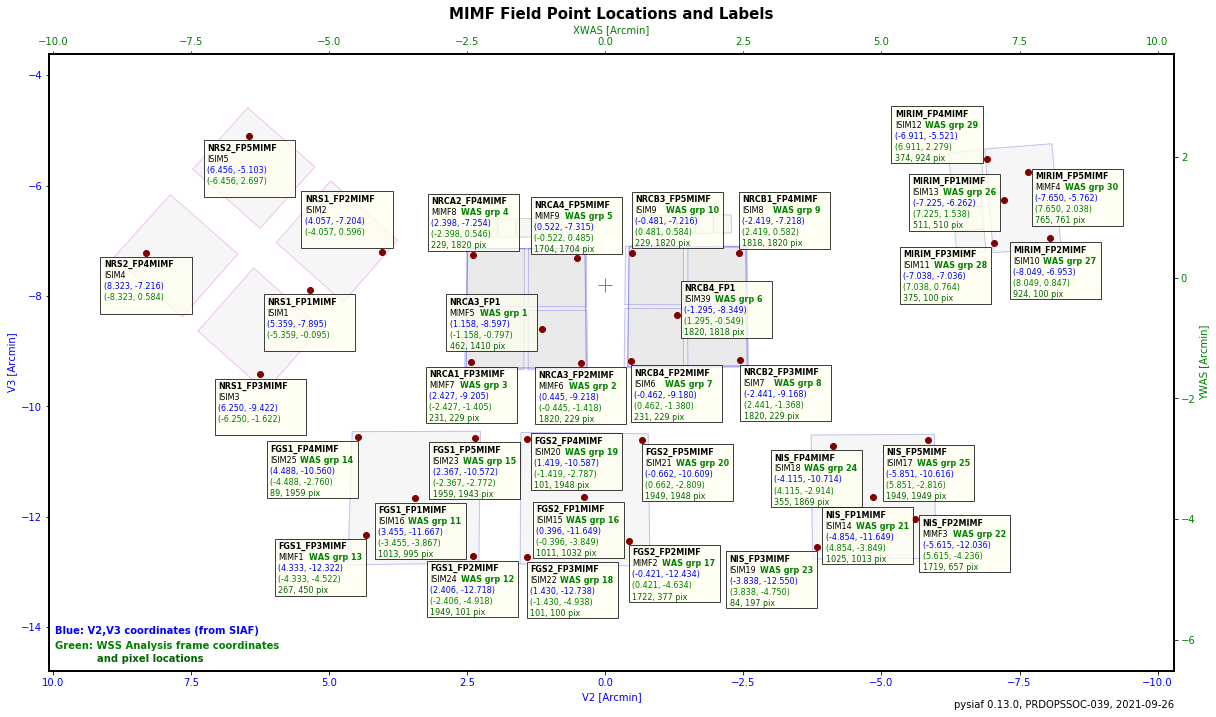

In [92]:
%pylab inline
import pysiaf
import webbpsf

fig = plt.figure(figsize=(17,10))
ax = plt.gca()
ap_color='maroon'
color_box = 'ivory'
color_det = 'gainsboro'


pysiaf.siaf.plot_main_apertures(ax=ax, units='arcmin', fill=True, 
                                fill_color=color_det, zorder=-1, fill_alpha=0.25, 
                                alpha=0.2)
ax.set_xlabel("V2 [Arcmin]", color='blue')
ax.set_ylabel("V3 [Arcmin]", color='blue')


#ax.patch.set_facecolor('0.75')

text_angle = 0

text_align_left = ['NRCB1_FP4MIMF','NRCB2_FP3MIMF', 'NRCB4_FP2MIMF', 'NRCB3_FP5MIMF',
                   'FGS2_FP4MIMF', 'FGS2_FP3MIMF', 'FGS2_FP5MIMF', 'FGS2_FP2MIMF',
                   'NIS_FP2MIMF',  'MIRIM_FP5MIMF']  # 'MIRIM_FP2MIMF',

text_align_right = ['MIRIM_FP1MIMF', 'MIRIM_FP3MIMF','MIRIM_FP4MIMF',
                    'FGS1_FP3MIMF', 'FGS1_FP4MIMF', 'NIS_FP3MIMF',
                     'NRS1_FP2MIMF']

box_align_bottom = ['NRCB1_FP4MIMF', 'NRCB3_FP5MIMF', 'NRS1_FP2MIMF','NRCA2_FP4MIMF','NRCA4_FP5MIMF',
                   'MIRIM_FP4MIMF']

def label_offset(fpname):
    special_offsets = {'NRCA3_FP1': (0.9, 0.7),
                       'NRCB4_FP1': (-0.9, 0.7),
                      'MIRIM_FP4MIMF': (0.08, -0.15),
                      'MIRIM_FP3MIMF': (0.05, -0.0),
                      'MIRIM_FP1MIMF': (0.07, 0.55),
                      'MIRIM_FP5MIMF': (-0.07, 0.14),
                       'MIRIM_FP2MIMF': (-0.1, 0),
                      'NRS1_FP2MIMF': (-0.2, 0),
                      'FGS1_FP1MIMF': (-0.1, 0),
                       'FGS2_FP1MIMF': (0.1, 0),
                       'FGS2_FP4MIMF': (-0.07, 0.17),
                       'NIS_FP1MIMF': (0.1, -0.1),
                       'NIS_FP2MIMF': (-0.07, 0.14),
                       'NIS_FP3MIMF': (0.0, 0),
                       'NIS_FP4MIMF': (0.3, 0)}
    
    return special_offsets.get(fpname, (0,0))


text_kws = {'verticalalignment':'top',
           'horizontalalignment':h_align,
           'rotation':text_angle,
           'fontsize': 8}

def textbox(v2,v3, offset, ap, h_align='center', v_align='top'):

    # Values we will show in the text box
    WSS_XAN = -ap.V2Ref/60
    WSS_YAN = (ap.V3Ref+468)/60

    isim_name = closest_isim_fp_name(ap.V2Ref/60, ap.V3Ref/60)
    
    if ap.AperName.startswith('NRS'):
        wag_group = None
    else:
        wag_group = closest_wag_fp_group(WSS_XAN, WSS_YAN)
 
    # Where will we plot the text box?
    c0 = v2+offset[0]
    c1 = v3+offset[1] -0.075
    bw = 1.65
    bh = 1.03
    if h_align=='center':
        c0+= bw/2
    elif h_align=='right':
        c0+= bw
             
    if v_align=='bottom':
        c1+=bh+0.15
        
        
    # Draw the text box
    lh=0.20
    rect = patches.Rectangle((c0-bw,c1-bh), bw, bh, 
                             linewidth=1, edgecolor='k', facecolor=color_box, alpha=0.75)
    # Add the patch to the Axes
    ax.add_patch(rect) 

    margin=0.06
    plt.text(c0-margin, c1-margin,
             f"{ap.AperName}", 
             color='black', fontweight='bold',
             **text_kws)
    plt.text(c0-margin, c1-margin-lh,
             f"{isim_name}", 
             color='black', fontweight='normal',
             **text_kws)
    if wag_group is not None:
        plt.text(c0-margin-0.55, c1-margin-lh,
                 f"WAS grp {wag_group}", 
                 color='green', fontweight='bold',
                 **text_kws)
        plt.text(c0-margin, c1-margin-lh*4,
             f"{round(ap.XSciRef)}, {round(ap.YSciRef):} pix", color='darkgreen', 
             **text_kws)
 
    plt.text(c0-margin, c1-margin-lh*2,
             f"({ap.V2Ref/60:.3f}, {(ap.V3Ref)/60:.3f})", color='blue', 
             **text_kws)
    plt.text(c0-margin, c1-margin-lh*3,
             f"({WSS_XAN:.3f}, {WSS_YAN:.3f})", color='green', 
             **text_kws)
   

for instname in webbpsf.instrument.list + ['fgs']:
    siaf = pysiaf.Siaf(instname)
    mimf_aperture_names = [m for m in siaf.apernames if ('MIMF' in m or m.endswith('_FP1'))]
    for apname in mimf_aperture_names:
        ap = siaf[apname]
        plt.scatter(ap.V2Ref/60, ap.V3Ref/60, marker='o', color=ap_color)
                    
        h_align = 'left' if ap.AperName in text_align_left else 'right' if ap.AperName in text_align_right else 'center'
        v_align = 'bottom' if ap.AperName in box_align_bottom else 'top'
        
        
        offset = label_offset(apname)
    
        
        textbox(ap.V2Ref/60, ap.V3Ref/60, offset, ap, h_align=h_align, v_align=v_align)
        



ax.set_title("MIMF Field Point Locations and Labels", fontweight='heavy', fontsize=15)

isodate = datetime.datetime.now().isoformat()[0:10]
plt.text(1.0, -0.06, f"pysiaf {pysiaf.__version__}, {pysiaf.JWST_PRD_VERSION}, {isodate}",
         transform=ax.transAxes, horizontalalignment='right',)

plt.text(0.005, 0.06, f"Blue: V2,V3 coordinates (from SIAF)",
         transform=ax.transAxes, horizontalalignment='left', fontweight='bold',
         color='blue')
plt.text(0.005, 0.035, f"Green: WSS Analysis frame coordinates",
         transform=ax.transAxes, horizontalalignment='left', fontweight='bold',
         color='green')
plt.text(0.005, 0.015, f"            and pixel locations",
         transform=ax.transAxes, horizontalalignment='left', fontweight='bold',
         color='darkgreen')
ax.scatter(0, -468/60, 200, marker='+', color='black', alpha=0.5) # Mark master chief ray (XAN/YAN origin)

#plt.savefig("mimf_field_point_locations_for_was.pdf")

#ax.set_xlim(-9.5, 9.5)
#ax.set_ylim(-14.5, -4.5)

reference_plot_xlim = ax.get_xlim()
reference_plot_ylim = ax.get_ylim()


# Set up additional axes labels in the coords that the WSS uses
ax_wasy = ax.twinx()
ax_wasy.set_ylabel("YWAS [Arcmin]", color='green')
ax_wasy.set_ylim(*(np.asarray(ax.get_ylim())+468/60))


ax_wasx = ax_wasy.twiny()
ax_wasx.set_xlabel("XWAS [Arcmin]", color='green')
ax_wasx.set_xlim(*(-np.asarray(ax.get_xlim())))


ax_wasy.set_ylim(*(np.asarray(ax.get_ylim())+468/60))
[t.set_color('green') for t in ax_wasy.yaxis.get_ticklabels()]
[t.set_color('green') for t in ax_wasx.xaxis.get_ticklabels()]
[t.set_color('blue') for t in ax.yaxis.get_ticklabels()]
[t.set_color('blue') for t in ax.xaxis.get_ticklabels()]

plt.tight_layout()


plt.savefig("draft_new_mimf_points_plot.pdf")


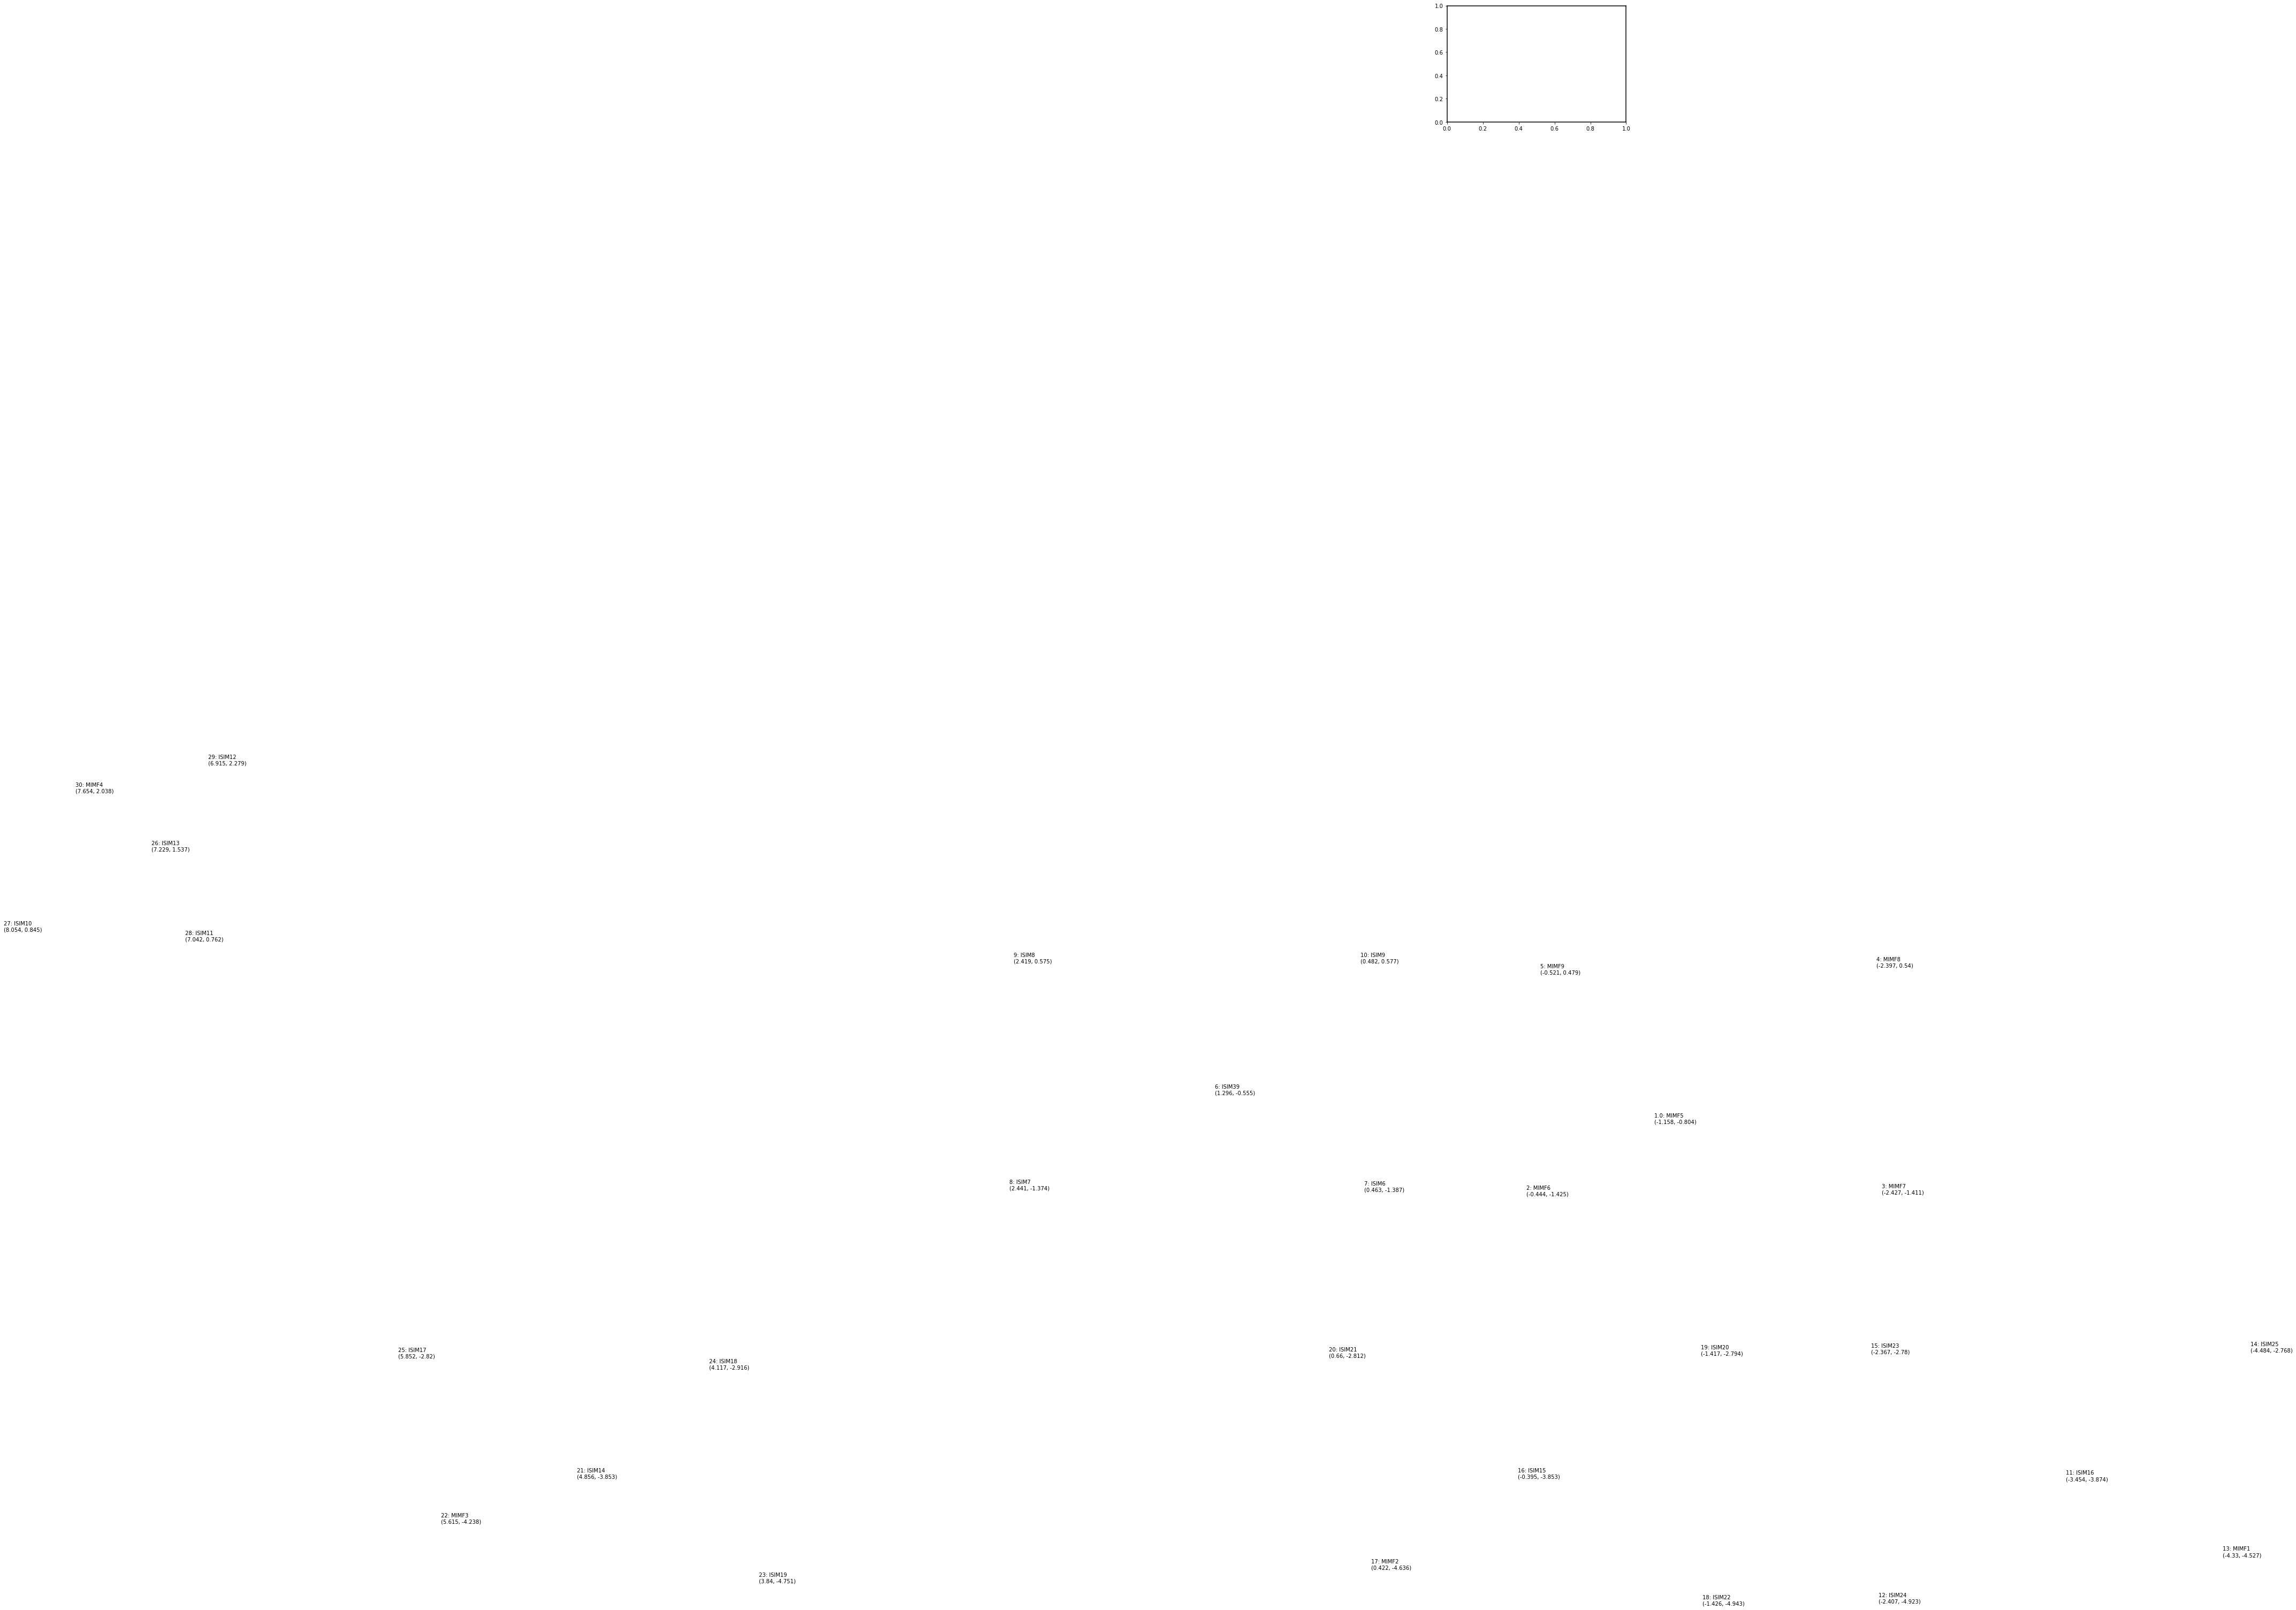

In [8]:
for group, fp, v2v3 in zip(wag_group, wag_fps, wag_v2v3):
#    print(v2v3)
    v2v3array = np.asarray(v2v3.split(','), float)
    plt.text( -v2v3array[0], v2v3array[1]-468/60, f"{group}: {fp}\n({v2v3})", rotation=0)

In [9]:
1./60

0.016666666666666666

Guider1 4.243813001 -12.204481009 ASPAG1A
Guider1 4.098480105 -12.106938738 ASPAI7
Guider1 4.271962184 -12.105763815 ASPAI8
Guider1 4.273972465 -12.279071723 ASPAI9
Guider1 3.453836292 -11.673627677999999 ISIM16
included!
Guider1 2.367101704 -10.5800444 ISIM23
included!
Guider1 2.407340073 -12.722804833 ISIM24
included!
Guider1 4.483951427 -10.568410667 ISIM25
included!
Guider1 4.539288568 -12.750708227 ISIM35
included!
Guider1 4.330263734 -12.327364324 MIMF1
included!
Guider2 -0.365826326 -12.270827115 ASPAG2A
Guider2 -0.425843184 -12.102382123 ASPAI11
Guider2 -0.251058964 -12.275439197 ASPAI13
Guider2 0.394868751 -11.653243996 ISIM15
included!
Guider2 1.416902865 -10.594137467 ISIM20
included!
Guider2 -0.659922505 -10.612091906 ISIM21
included!
Guider2 1.425733449 -12.742785048 ISIM22
included!
Guider2 -0.689250947 -12.780363594 ISIM36
included!
Guider2 -0.422007844 -12.435712370000001 MIMF2
included!
MIRI -8.053510053 -6.954861766 ISIM10
included!
MIRI -7.041573127 -7.038164629 ISIM

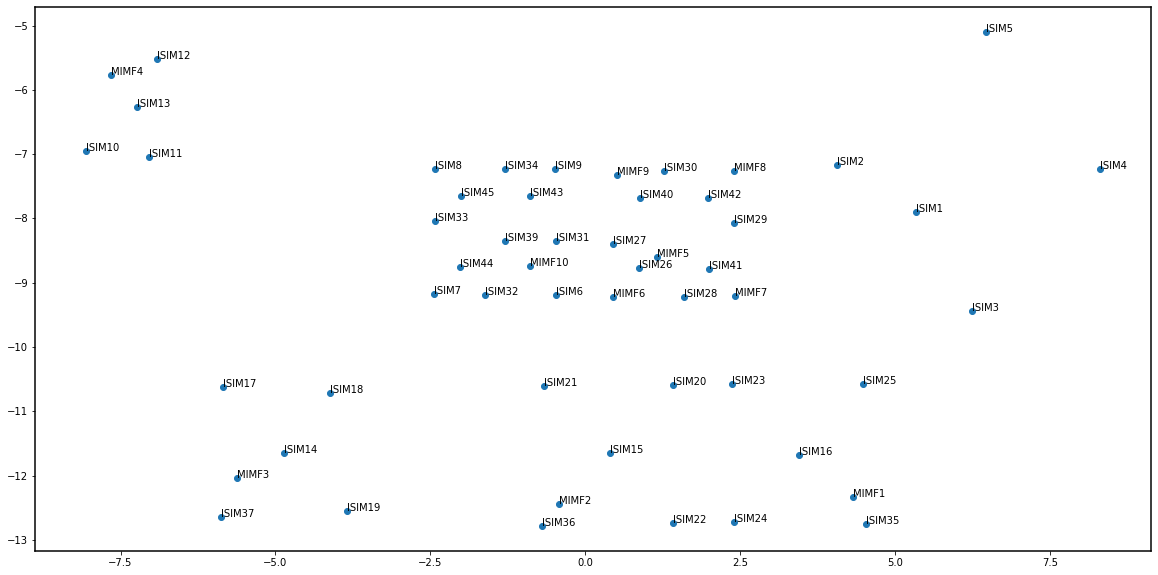

In [10]:
fpnames = isimdata['field_point_name']

def include_this_fp(row):
    fpname = row['field_point_name']
    instname = row['instrument']
    return not (fpname.startswith('ASPA') or fpname.startswith('Q') or instname.startswith('NIRCamLW'))

include_fp = [include_this_fp(row) for row in isimdata]

plt.figure(figsize=(20,10))
plt.scatter(isimdata['V2'][include_fp], isimdata['V3'][include_fp])

for row in isimdata:
    print(row['instrument'], row['V2'], row['V3'],row['field_point_name'])
    if include_this_fp(row):
        print("included!")
        plt.text(row['V2'], row['V3'],row['field_point_name'] )

In [11]:
np.asarray(include_fp).sum(), 5+6*3+5+13*2

(54, 54)

In [12]:
set(isimdata['instrument'])

{'Guider1',
 'Guider2',
 'MIRI',
 'NIRCamLWA',
 'NIRCamLWB',
 'NIRCamSWA',
 'NIRCamSWB',
 'NIRISS',
 'NIRSpec'}

# Read WAG field points too

In [13]:
# Read WAG field point info too

import openpyxl
from openpyxl import load_workbook

wb = load_workbook(filename = 'MIMF_FP_Table_From_WAG.xlsx')
sheet = wb['Sheet1']

wag_group = [c[0].value for c in sheet['A5:A34']]
wag_fps = [c[0].value for c in sheet['B5:B34']]
wag_v2v3 = [c[0].value for c in sheet['F5:F34']]



In [14]:



wag_fps

['MIMF5',
 'MIMF6',
 'MIMF7',
 'MIMF8',
 'MIMF9',
 'ISIM39',
 'ISIM6',
 'ISIM7',
 'ISIM8',
 'ISIM9',
 'ISIM16',
 'ISIM24',
 'MIMF1',
 'ISIM25',
 'ISIM23',
 'ISIM15',
 'MIMF2',
 'ISIM22',
 'ISIM20',
 'ISIM21',
 'ISIM14',
 'MIMF3',
 'ISIM19',
 'ISIM18',
 'ISIM17',
 'ISIM13',
 'ISIM10',
 'ISIM11',
 'ISIM12',
 'MIMF4']

In [15]:
wag_group

['1 *',
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

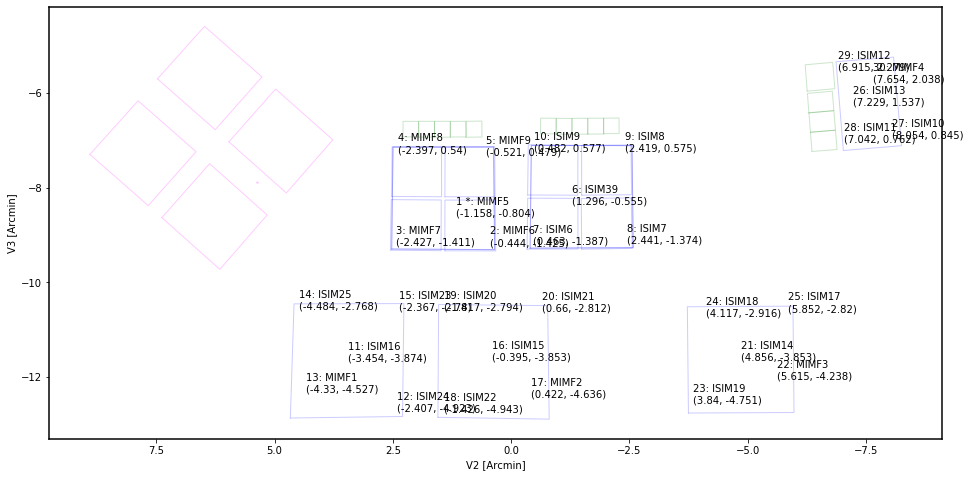

In [16]:

fig = plt.figure(figsize=(16,8))
ax = plt.gca()
ap_color='maroon'

pysiaf.siaf.plot_main_apertures(ax=ax, units='arcmin', fill=True, 
                                fill_color='white', zorder=-1, fill_alpha=0.25, 
                                alpha=0.2)
ax.set_xlabel("V2 [Arcmin]")
ax.set_ylabel("V3 [Arcmin]")


for group, fp, v2v3 in zip(wag_group, wag_fps, wag_v2v3):
#    print(v2v3)
    v2v3array = np.asarray(v2v3.split(','), float)
    plt.text( -v2v3array[0], v2v3array[1]-468/60, f"{group}: {fp}\n({v2v3})", rotation=0)

Populating the interactive namespace from numpy and matplotlib


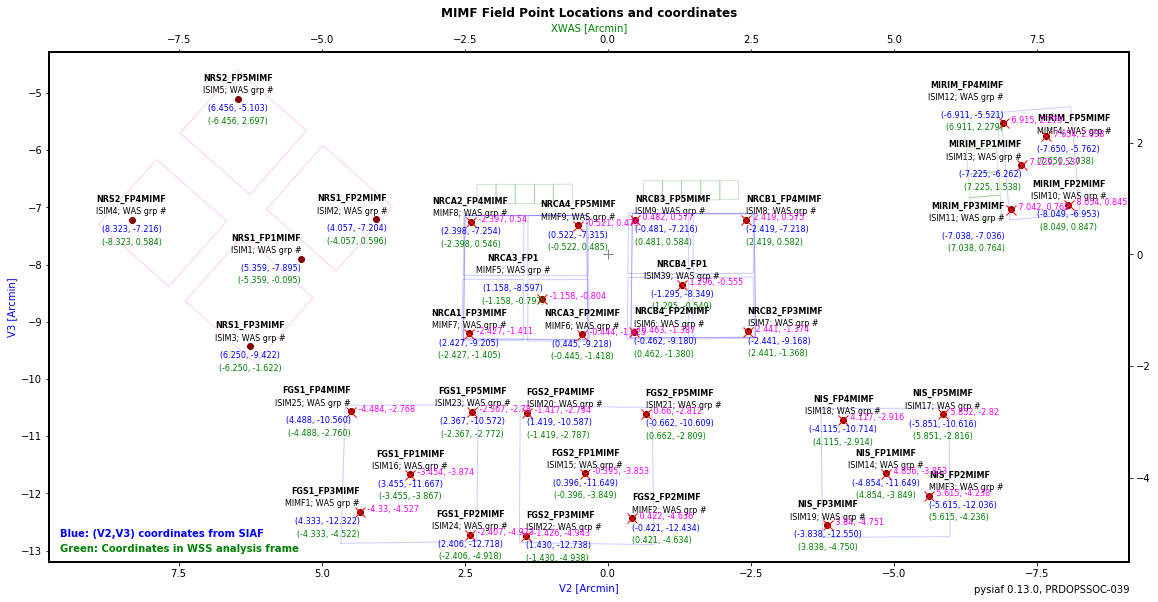

In [17]:
# THis version cross-compares the SIAF points and the values in teh WAG
# Bottom line is they agree well.

%pylab inline
import pysiaf
import webbpsf

fig = plt.figure(figsize=(16,8))
ax = plt.gca()
ap_color='maroon'

pysiaf.siaf.plot_main_apertures(ax=ax, units='arcmin', fill=True, 
                                fill_color='white', zorder=-1, fill_alpha=0.25, 
                                alpha=0.2)
ax.set_xlabel("V2 [Arcmin]", color='blue')
ax.set_ylabel("V3 [Arcmin]", color='blue')


#ax.patch.set_facecolor('0.75')

text_angle = 0

text_align_left = ['NRCB1_FP4MIMF','NRCB2_FP3MIMF', 'NRCB4_FP2MIMF', 'NRCB3_FP5MIMF',
                   'FGS2_FP4MIMF', 'FGS2_FP3MIMF', 'FGS2_FP5MIMF', 'FGS2_FP2MIMF',
                   'NIS_FP2MIMF',  'MIRIM_FP5MIMF']  # 'MIRIM_FP2MIMF',

text_align_right = ['MIRIM_FP1MIMF', 'MIRIM_FP3MIMF','MIRIM_FP4MIMF',
                    'FGS1_FP3MIMF', 'FGS1_FP4MIMF',
                    'NRS1_FP1MIMF', 'NRS1_FP2MIMF']


def label_offset(fpname):
    special_offsets = {'NRCA3_FP1': (0.5, 0.35),
                      'MIRIM_FP4MIMF': (0, 0.3),
                      'MIRIM_FP3MIMF': (0.1, -0.3),
                      'MIRIM_FP5MIMF': (0.15, -0.05),
                      'NRS1_FP2MIMF': (-0.2, 0)}
    
    return special_offsets.get(fpname, (0,0))


for instname in webbpsf.instrument.list + ['fgs']:
    siaf = pysiaf.Siaf(instname)
    mimf_aperture_names = [m for m in siaf.apernames if ('MIMF' in m or m.endswith('_FP1'))]
    for apname in mimf_aperture_names:
        ap = siaf[apname]
        plt.scatter(ap.V2Ref/60, ap.V3Ref/60, marker='o', color=ap_color)
                    
        h_align = 'left' if ap.AperName in text_align_left else 'right' if ap.AperName in text_align_right else 'center'
        
        WSS_XAN = -ap.V2Ref/60
        WSS_YAN = (ap.V3Ref+468)/60
        
        isim_name = closest_isim_fp_name(ap.V2Ref/60, ap.V3Ref/60)
        
        offset = label_offset(apname)
        
        text_kws = {'verticalalignment':'top',
                   'horizontalalignment':h_align,
                   'rotation':text_angle,
                   'fontsize': 8}
        
        
        plt.text(ap.V2Ref/60+offset[0], ap.V3Ref/60+0.44+offset[1],
                 f"{ap.AperName}", 
                 color='black', fontweight='bold',
                 **text_kws)
        plt.text(ap.V2Ref/60+offset[0], ap.V3Ref/60+0.44+offset[1]-0.22,
                 f"{isim_name}; WAS grp #", 
                 color='black', fontweight='normal',
                 **text_kws)
        plt.text(ap.V2Ref/60+offset[0], ap.V3Ref/60-0.09+offset[1],
                 f"({ap.V2Ref/60:.3f}, {(ap.V3Ref)/60:.3f})", color='blue', 
                 **text_kws)
        plt.text(ap.V2Ref/60+offset[0], ap.V3Ref/60-0.09+offset[1]-0.22,
                 f"({WSS_XAN:.3f}, {WSS_YAN:.3f})", color='green', 
                 **text_kws)


#         plt.text(ap.V2Ref/60, ap.V3Ref/60-0.24, f"({WSS_XAN:.3f}, {(WSS_YAN)/60:.3f})", color='blue',
#                 verticalalignment='top',
#                 horizontalalignment=h_align,
#                  rotation=text_angle)
ax.set_title("MIMF Field Point Locations and coordinates", fontweight='heavy')

plt.text(1.0, -0.06, f"pysiaf {pysiaf.__version__}, {pysiaf.JWST_PRD_VERSION}",
         transform=ax.transAxes, horizontalalignment='right',)

plt.text(0.01, 0.05, f"Blue: (V2,V3) coordinates from SIAF",
         transform=ax.transAxes, horizontalalignment='left', fontweight='bold',
         color='blue')
plt.text(0.01, 0.02, f"Green: Coordinates in WSS analysis frame",
         transform=ax.transAxes, horizontalalignment='left', fontweight='bold',
         color='green')


for group, fp, v2v3 in zip(wag_group, wag_fps, wag_v2v3):
#    print(v2v3)
    v2v3array = np.asarray(v2v3.split(','), float)
    plt.scatter(-v2v3array[0], v2v3array[1]-468/60, s=100, marker='x', color='red')
    plt.text( -v2v3array[0], v2v3array[1]-468/60, f"   {v2v3}",fontsize=8, color='magenta')



plt.tight_layout()
#plt.savefig("mimf_field_point_locations_for_was.pdf")

reference_plot_xlim = ax.get_xlim()
reference_plot_ylim = ax.get_ylim()


# Set up additional axes labels in the coords that the WSS uses
ax_was = ax.twinx().twiny()
ax_was.set_xlabel("XWAS [Arcmin]", color='green')
ax_was.set_ylabel("YWAS [Arcmin]", color='green')
ax_was.set_xlim(*(-np.asarray(ax.get_xlim())))
ax_was.set_ylim(*(np.asarray(ax.get_ylim())+468/60))

ax_was.scatter(0,0, s=100, marker='+', color='black', alpha=0.5 )

Populating the interactive namespace from numpy and matplotlib


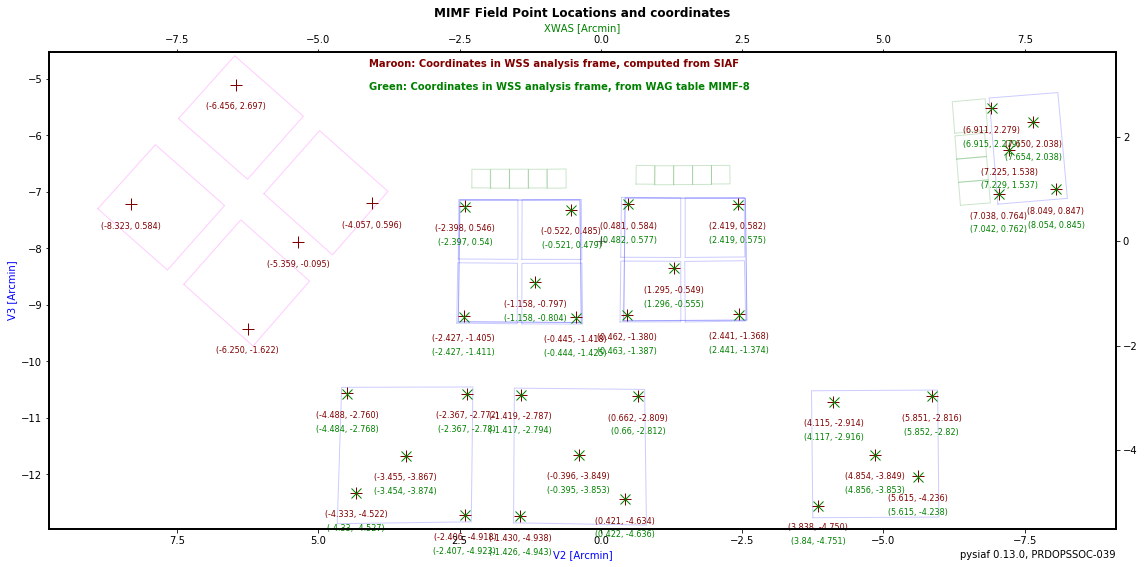

In [44]:
# THis version cross-compares the SIAF points and the values in teh WAG
# Bottom line is they agree well.

%pylab inline
import pysiaf
import webbpsf

fig = plt.figure(figsize=(16,8))
ax = plt.gca()
ap_color='maroon'

pysiaf.siaf.plot_main_apertures(ax=ax, units='arcmin', fill=True, 
                                fill_color='white', zorder=-1, fill_alpha=0.25, 
                                alpha=0.2)
ax.set_xlabel("V2 [Arcmin]", color='blue')
ax.set_ylabel("V3 [Arcmin]", color='blue')


#ax.patch.set_facecolor('0.75')

text_angle = 0

text_align_left = ['NRCB1_FP4MIMF','NRCB2_FP3MIMF', 'NRCB4_FP2MIMF', 'NRCB3_FP5MIMF',
                   'FGS2_FP4MIMF', 'FGS2_FP3MIMF', 'FGS2_FP5MIMF', 'FGS2_FP2MIMF',
                   'NIS_FP2MIMF',  'MIRIM_FP5MIMF']  # 'MIRIM_FP2MIMF',

text_align_right = ['MIRIM_FP1MIMF', 'MIRIM_FP3MIMF','MIRIM_FP4MIMF',
                    'FGS1_FP3MIMF', 'FGS1_FP4MIMF',
                    'NRS1_FP1MIMF', 'NRS1_FP2MIMF']


def label_offset(fpname):
    special_offsets = {'NRCA3_FP1': (0.5, 0.35),
                      'MIRIM_FP4MIMF': (0, 0.3),
                      'MIRIM_FP3MIMF': (0.1, -0.3),
                      'MIRIM_FP5MIMF': (0.15, -0.05),
                      'NRS1_FP2MIMF': (-0.2, 0)}
    
    return special_offsets.get(fpname, (0,0))


for instname in webbpsf.instrument.list + ['fgs']:
    siaf = pysiaf.Siaf(instname)
    mimf_aperture_names = [m for m in siaf.apernames if ('MIMF' in m or m.endswith('_FP1'))]
    for apname in mimf_aperture_names:
        ap = siaf[apname]
        plt.scatter(ap.V2Ref/60, ap.V3Ref/60, s=150, marker='+', color=ap_color)
                    
        h_align = 'left' if ap.AperName in text_align_left else 'right' if ap.AperName in text_align_right else 'center'
        
        WSS_XAN = -ap.V2Ref/60
        WSS_YAN = (ap.V3Ref+468)/60
        
        isim_name = closest_isim_fp_name(ap.V2Ref/60, ap.V3Ref/60)
        
        offset = label_offset(apname)
        
        
        h_align='center'


        text_kws = {'verticalalignment':'top',
                   'horizontalalignment':h_align,
                   'rotation':text_angle,
                   'fontsize': 8}
      
        plt.text(ap.V2Ref/60, ap.V3Ref/60-0.09-0.22,
                 f"({WSS_XAN:.3f}, {WSS_YAN:.3f})", color='maroon', 
                 **text_kws)


#         plt.text(ap.V2Ref/60, ap.V3Ref/60-0.24, f"({WSS_XAN:.3f}, {(WSS_YAN)/60:.3f})", color='blue',
#                 verticalalignment='top',
#                 horizontalalignment=h_align,
#                  rotation=text_angle)
ax.set_title("MIMF Field Point Locations and coordinates", fontweight='heavy')

plt.text(1.0, -0.06, f"pysiaf {pysiaf.__version__}, {pysiaf.JWST_PRD_VERSION}",
         transform=ax.transAxes, horizontalalignment='right',)

plt.text(0.3, 0.92, f"Green: Coordinates in WSS analysis frame, from WAG table MIMF-8",
         transform=ax.transAxes, horizontalalignment='left', fontweight='bold',
         color='green')

plt.text(0.3, 0.97, f"Maroon: Coordinates in WSS analysis frame, computed from SIAF",
         transform=ax.transAxes, horizontalalignment='left', fontweight='bold',
         color='maroon')




for group, fp, v2v3 in zip(wag_group, wag_fps, wag_v2v3):
#    print(v2v3)
    v2v3array = np.asarray(v2v3.split(','), float)
    plt.scatter(-v2v3array[0], v2v3array[1]-468/60, s=100, marker='x', color='green')
    plt.text( -v2v3array[0], v2v3array[1]-468/60-0.22*2.5, f"({v2v3})", 
             color='green',

             **text_kws)



plt.tight_layout()
#plt.savefig("mimf_field_point_locations_for_was.pdf")

reference_plot_xlim = ax.get_xlim()
reference_plot_ylim = ax.get_ylim()


# Set up additional axes labels in the coords that the WSS uses
ax_was = ax.twinx().twiny()
ax_was.set_xlabel("XWAS [Arcmin]", color='green')
ax_was.set_ylabel("YWAS [Arcmin]", color='green')
ax_was.set_xlim(*(-np.asarray(ax.get_xlim())))
ax_was.set_ylim(*(np.asarray(ax.get_ylim())+468/60))

ax_was.scatter(0,0, s=100, marker='+', color='black', alpha=0.5 )

plt.tight_layout()
plt.savefig("MIMF_FP_comparison_SIAF_vs_WAG.pdf")